# Example Use of Lignin-KMC
Written by: Michael Orella <br>
2019 January 23 <br>
Updated by: Heather Mayes <br>
2019 November 09 <br>

This notebook contains brief examples of how to use the Lignin-KMC package within python. Further examples are available in the [LigninPolymerizationNotebook.ipynb](LigninPolymerizationNotebook.ipynb). The methodology is discussed in ["Lignin-KMC: A Toolkit for Simulating Lignin Biosynthesis"](https://pubs.acs.org/doi/abs/10.1021/acssuschemeng.9b03534), and uses data reported in [DFT calculations of monolignol coupling kinetics](https://pubs.acs.org/doi/abs/10.1021/acssuschemeng.9b02506).

**Note:** this notebook directly calls various functions in the package. Users can also run Lignin-KMC from the command line, without the need to directly interact with the python code. See the [README on github](https://github.com/michaelorella/lignin-kmc).

In [1]:
%load_ext autoreload
%autoreload 2

Among other packages, individual functions and global variables from the ligninkmc are imported.

In [2]:
import numpy as np

# Chemical Drawing
from rdkit.Chem import MolFromMolBlock
from rdkit.Chem.AllChem import Compute2DCoords
from rdkit.Chem.Draw import MolToImage
from IPython.display import display

# Lignin-KMC functions and global variables used in this notebook
from ligninkmc.monomer import Monomer
from ligninkmc.event import Event
from ligninkmc.kmc_functions import run_kmc
from ligninkmc.analysis import analyze_adj_matrix, adj_analysis_to_stdout
from ligninkmc.visualization import generate_mol
from ligninkmc.create_lignin import (calc_rates, create_initial_monomers, create_initial_events, 
                                     create_initial_state)
from ligninkmc.kmc_common import (DEF_E_A_KCAL_MOL, ADJ_MATRIX, MONO_LIST, MONOMER, OX, GROW)

## SG Lignin Example

The first step of this example is for us to define the rates of bond formation, oxidation, and hydration. This is done by using a dictionary that maps the bond string ('5o4', 'bo4', 'b5', '55', 'bb', 'ao4', etc., saved as the global variables  C5O4, BO4, B4, C5C5, BB, AO4, etc.) to a dictionary that maps monomer type (0 - coniferyl, 1 - sinapyl, 2 - caffeoyl) to a dictionary that maps fragment sizes to be joined (e.g. ('monomer', 'dimer'), where 'dimer' represents dimer or longer oligomers) to the transition state energy barriers in kcal/mol. 

Here, we will use the default values, as reported in the [Lignin-KMC paper](https://pubs.acs.org/doi/abs/10.1021/acssuschemeng.9b03534), [Tables S1 and S2](https://pubs.acs.org/doi/suppl/10.1021/acssuschemeng.9b03534/suppl_file/sc9b03534_si_001.pdf), which stored in the package's global variable DEF_E_A_KCAL_MOL (imported above). 

These values can be tuned and updated to reflect new developments in better understanding of lignin chemistry. The format of the expected dictionary is shown in the [LigninPolymerizationNotebook.ipynb](LigninPolymerizationNotebook.ipynb).

Once the values have been input or imported, the `calc_rates` function uses the Eyring equation to calculate an equivalent dictionary (bond types) of dictionaries (substrate monomer types) of dictionaries (fragment sizes of substrates) of rates.

$$ r_i = \dfrac{k_BT}{h}\exp\left(-\dfrac{\Delta G_i}{k_BT}\right) $$

In [3]:
# Calculate the rates of reaction in 1/s at the specified temp
temp = 298.15  # K
rxn_rates = calc_rates(temp, ea_kcal_mol_dict=DEF_E_A_KCAL_MOL)

With the rates generated, we initialize the simulation with a set of monomers, and the ratio of S and G units that should be incorporated. 

In [4]:
# Set the percentage of S
sg_ratio = 1
pct_s = sg_ratio / (1 + sg_ratio)

# Set the initial and maximum number of monomers to be modeled.
ini_num_monos = 2
max_num_monos = 10

# Maximum time to simulate, in seconds
t_max = 1  # seconds
mono_add_rate = 1e4  # monomers/second

# Use a random number and the given sg_ratio to determine the monolignol types to be initially modeled
monomer_draw = np.random.rand(ini_num_monos)
initial_monomers = create_initial_monomers(pct_s, monomer_draw)

# Initially allow only oxidation events. After they are used to determine the initial state, add 
#     GROW to the events, which allows additional monomers to be added to the reaction at the 
#     specified rate and with the specified ratio
initial_events = create_initial_events(monomer_draw, pct_s, rxn_rates)
initial_state = create_initial_state(initial_events, initial_monomers)
initial_events.append(Event(GROW, [], rate=mono_add_rate, bond=sg_ratio))

Now lignin creation can be simulated with `run_kmc`. A final time is specified in addition to the maximum number of monomers to model (defined above). The simulation will stop either when the maximum time is reached or no more reactions are possible, whichever happens first. 

To show the end state, we will print the adjacency matrix that has been generated, although this is not the typical output examined. Each row represents a monomer. If there is a number in a column, the monomer is joined to the monomer index corresponding to the column index, at the atom position specified by that number.

In [5]:
result = run_kmc(n_max=max_num_monos, t_final=t_max, rates=rxn_rates, sg_ratio=sg_ratio,
                 initial_state=initial_state, initial_events=initial_events)

# Convert the sparse matrix to a full array before printing
print("The adjacency matrix for the simulated lignin is:")
print(result[ADJ_MATRIX].toarray())

The adjacency matrix for the simulated lignin is:
[[0. 8. 4. 0. 0. 0. 0. 0. 0. 0.]
 [5. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [8. 0. 0. 0. 0. 4. 0. 0. 0. 0.]
 [0. 0. 0. 0. 5. 0. 0. 0. 0. 0.]
 [0. 0. 0. 8. 0. 4. 0. 0. 0. 0.]
 [0. 0. 5. 0. 8. 0. 4. 0. 0. 0.]
 [0. 0. 0. 0. 0. 8. 0. 5. 0. 0.]
 [0. 0. 0. 0. 0. 0. 8. 0. 4. 0.]
 [0. 0. 0. 0. 0. 0. 0. 8. 0. 4.]
 [0. 0. 0. 0. 0. 0. 0. 0. 8. 0.]]


With our results in place, we go about analyzing them using the "analyze" functionality.

In [6]:
summary = analyze_adj_matrix(result[ADJ_MATRIX])
adj_analysis_to_stdout(summary)

Lignin KMC created 10 monomers, which formed:
       1 oligomer(s) of chain length 10
composed of the following bond types and number:
     55:    0    5O4:    1    AO4:    0     B1:    0     B5:    3     BB:    0    BO4:    5

Breaking C-O bonds to simulate RCF results in:
       4 monomer(s) (chain length 1)
       3 dimer(s) (chain length 2)
with following remaining bond types and number:
     55:    0    5O4:    0    AO4:    0     B1:    0     B5:    3     BB:    0    BO4:    0


While the analysis is nice for the purpose of seeing macroscopic results, we can use the RDKit package to visualize the molecular fragments.

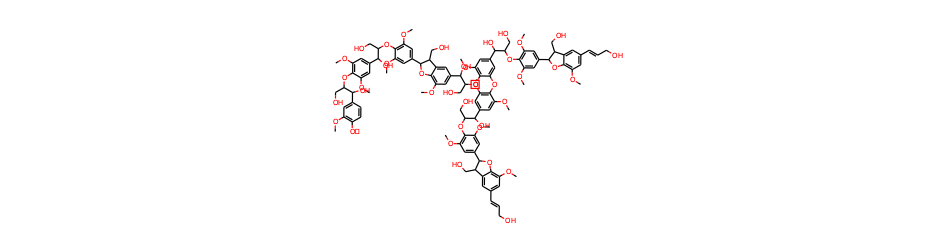

In [7]:
nodes = result[MONO_LIST]
adj = result[ADJ_MATRIX]
block = generate_mol(adj, nodes)
mol = MolFromMolBlock(block)
Compute2DCoords(mol)
display(MolToImage(mol, size=(950, 250)))

These results presented above will be dependent on each of the parameters that are chosen. Play around with the values of the parameters to see how the final structure changes. We will now go through a similar example using C-lignin instead of SG-lignin.

## C Lignin Example

The default energy barriers imported above include those for for C lignin. The corresponding reaction rates were calculated above. Thus, we are ready to define the initial state and simulation termination criteria.

In [8]:
ini_num_monos = 2
max_num_monos = 10

t_max = 1  # seconds
mono_add_rate = 1e4  # monomers/second

initial_monomers = [Monomer(2, i) for i in range(ini_num_monos)]
initial_events = [Event(OX, [i], rxn_rates[OX][2][MONOMER]) for i in range(ini_num_monos)]
initial_state = create_initial_state(initial_events, initial_monomers)
# An sg_ratio is not relevant and can be omitted
initial_events.append(Event(GROW, [], rate=mono_add_rate))
result = run_kmc(n_max=max_num_monos, t_final=t_max, rates=rxn_rates, initial_state=initial_state,
                 initial_events=initial_events)

summary = analyze_adj_matrixresult[ADJ_MATRIX])
adj_analysis_to_stdout(summary)

print("\nThe adjacency matrix for the simulated lignin is:")
print(result[ADJ_MATRIX].toarray())

Lignin KMC created 10 monomers, which formed:
       1 oligomer(s) of chain length 10
composed of the following bond types and number:
     55:    0    5O4:    0    AO4:    0     B1:    0     B5:    1     BB:    0    BO4:    8

Breaking C-O bonds to simulate RCF results in:
       8 monomer(s) (chain length 1)
       1 dimer(s) (chain length 2)
with following remaining bond types and number:
     55:    0    5O4:    0    AO4:    0     B1:    0     B5:    1     BB:    0    BO4:    0

The adjacency matrix for the simulated lignin is:
[[0. 8. 4. 0. 0. 0. 0. 0. 0. 0.]
 [5. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [8. 0. 0. 4. 0. 0. 0. 0. 0. 0.]
 [0. 0. 8. 0. 4. 0. 0. 0. 0. 0.]
 [0. 0. 0. 8. 0. 4. 0. 0. 0. 0.]
 [0. 0. 0. 0. 8. 0. 4. 0. 0. 0.]
 [0. 0. 0. 0. 0. 8. 0. 4. 0. 0.]
 [0. 0. 0. 0. 0. 0. 8. 0. 4. 0.]
 [0. 0. 0. 0. 0. 0. 0. 8. 0. 4.]
 [0. 0. 0. 0. 0. 0. 0. 0. 8. 0.]]


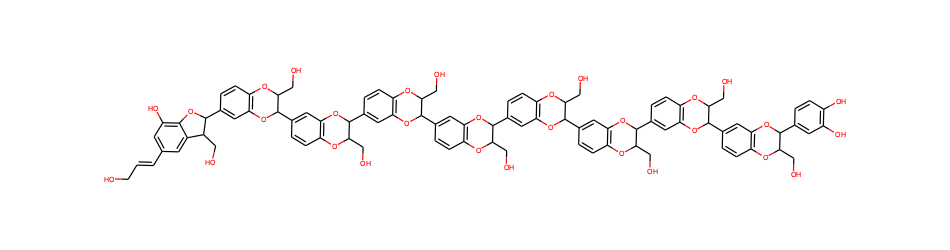

In [9]:
nodes = result[MONO_LIST]
adj = result[ADJ_MATRIX]
block = generate_mol(adj, nodes)
mol = MolFromMolBlock(block)
Compute2DCoords(mol)
display(MolToImage(mol, size=(950, 250)))

As previously noted, this package can be run from the command line. See also the package's [README](https://github.com/michaelorella/lignin-kmc) to see how.